## **Подгрузка используемых библиотек**

In [4]:
import warnings #https://github.com/hse-econ-data-science/andan_2023/blob/main/hw/hw03-logreg_must_suffer.ipynb
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import scipy.stats as sts
from sklearn.mixture import GaussianMixture
import random

In [5]:
rnd_seed = 42
np.random.seed(rnd_seed)
random.seed(rnd_seed)

## **Парсинг данных из источника - ШАГ 2**

К сожалению, данные из станции 276120 очень прерывистые, однако в них есть осадки и атмосферное давление, тогда как в данных с 275155 (Шереметьево) есть наблюдения за каждый год

Объденим эти два источника

In [6]:
# ставим True, только если ходим перезапросить все данные и заново сохранить в файл parsed_data.csv
reparse = True

In [7]:
year_start = 2009
yers_stop = 2021
columns = ['Дата', 'Максимальная температура', 'Минимальная температура', 'Средняя температура', 
           'Атмосферное давление', 'Скорость ветра', 'Осадки', 'Эффективная температура']

In [8]:
if reparse:
    station_main = 275155
    station_add = 276120
    url = "http://pogoda-service.ru/archive_gsod_res.php?country=RS&station={}&datepicker_beg=01.01.{}&datepicker_end=31.12.{}&bsubmit=%D0%9F%D0%BE%D1%81%D0%BC%D0%BE%D1%82%D1%80%D0%B5%D1%82%D1%8C"
    df_all = pd.DataFrame(columns=columns)

In [9]:
if reparse:
    df_all = pd.DataFrame(columns=columns)

    for year in range(year_start, yers_stop+1):
        df = pd.read_html(url.format(station_main, year, year))
        # выдавал ошибку в недостатке количества измерений, поэтому прибегли к следующему материалу:
        # https://developerknow.com/python-error-valueerror-must-pass-2-d-input-shape5-1-10-solution/
        df = np.array(df)
        # получаем количество дней(df.shape[1]), учитывая что год мог быть високосным
        df = np.reshape(df, (df.shape[1], 8))
        df = pd.DataFrame(df)
        df.columns = columns
        df = df.drop(['Атмосферное давление', 'Осадки'], axis=1)

        df_add = pd.read_html(url.format(station_add, year, year))
        df_add = np.array(df_add)
        df_add = np.reshape(df_add, (df_add.shape[1], 8))
        df_add = pd.DataFrame(df_add)
        df_add.columns = columns

        df = df.set_index('Дата').join(pd.DataFrame(df_add[['Дата', 'Атмосферное давление', 'Осадки']]).set_index('Дата'), how="left")
        df = df.reset_index()
        print(df.shape[0], year)
        df_all = pd.concat([df_all, df], axis=0, ignore_index=True)

365 2009
365 2010
365 2011
366 2012
365 2013
364 2014
364 2015
364 2016
364 2017
358 2018
361 2019
366 2020
362 2021


In [10]:
# анализируем пропуски
if reparse:
    print(df_all.dtypes)
    print((df_all.isna().sum()))
    df_all

Дата                        object
Максимальная температура    object
Минимальная температура     object
Средняя температура         object
Атмосферное давление        object
Скорость ветра              object
Осадки                      object
Эффективная температура     object
dtype: object
Дата                           0
Максимальная температура       6
Минимальная температура        6
Средняя температура            0
Атмосферное давление        1424
Скорость ветра                 0
Осадки                      1480
Эффективная температура        0
dtype: int64


In [11]:
if reparse:
    df_all["Осадки"] = df_all["Осадки"].fillna(0)
    df_all = df_all.fillna(method = 'bfill')
    print((df_all.isna().sum()))

Дата                        0
Максимальная температура    0
Минимальная температура     0
Средняя температура         0
Атмосферное давление        1
Скорость ветра              0
Осадки                      0
Эффективная температура     0
dtype: int64


In [12]:
if reparse:
    df_all.dropna(inplace=True, axis=0)

    df_all['Дата'] = pd.to_datetime(df_all['Дата'], dayfirst=True)

    # Преобразуем остальные колонки к типу float
    df_all[columns[1:]] = df_all[columns[1:]].astype(float)

    print(df_all.dtypes)
    df_all

Дата                        datetime64[ns]
Максимальная температура           float64
Минимальная температура            float64
Средняя температура                float64
Атмосферное давление               float64
Скорость ветра                     float64
Осадки                             float64
Эффективная температура            float64
dtype: object


По итогам предварительного анализа датасета по заявленной теме можно сделать следующие выводы (шаг 3):

В колонках содержатся следующие признаки:
1. "Дата" - datetime формат, дата фиксирования показателей
2. "Максимальная температура" - float формат (после обработки выше), максимальная температуры за сутки
3. "Минимальная температура" - float формат (после обработки выше), минимальная температура за сутки
4. "Средняя температура" - float формат (после обработки выше), среднесуточная температура
5. "Атмосферное давление" - float формат (после обработки выше), показатели атмосферного давления в единицах бар за сутки
6. "Скорость ветра" - float формат (после обработки выше), скорость ветра в м/с в конкретный день
7. "Осадки" - float формат (после обработки выше), зафиксированные за сутки осадков в мм
8. "Эффективная температура" - float формат (после обработки выше), комплексный показатель (совокупное воздействие температуры и влажности), влияющий на состояние человека, в градусах.
Где это было возможно, произошла замена NaN-значений на предыдущие ввиду наличия прецедента использования в исследованиях датасетов погоды, например: https://towardsdatascience.com/weather-forecasting-with-machine-learning-using-python-55e90c346647

!!! Было принято решение об увеличении количества рассматриваемых лет ввиду нехватки данных в изначально заявленных данных (общее число показателей до этого составляло порядка 700 наблюдений, что противоречит изначальному условию проекта).

Цель проекта - составить погодный портрет Москвы по данным метеорологической станции

Создаем файл csv и сохраняем туда данные

In [13]:
if reparse:
    df_all.to_csv("parsed_data.csv", index=False)

Теперь можем не парсить каждый раз данные, а просто читать csvшник

In [14]:
if not reparse:
    df_all = pd.read_csv("parsed_data.csv")
    df_all['Дата'] = pd.to_datetime(df_all['Дата'])

## **Визуализация - ШАГ 4** 


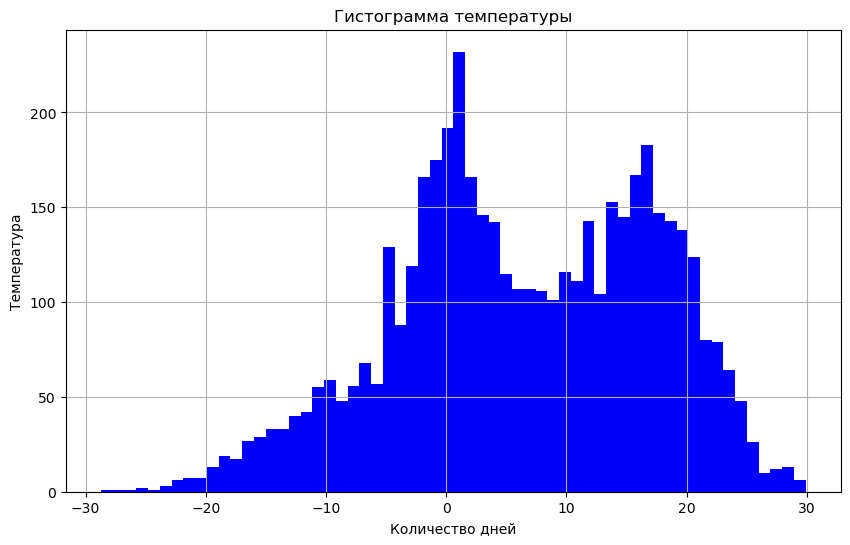

In [19]:
plt.figure(figsize=(10, 6))
df_all["Средняя температура"].hist(color ='blue', bins = 60, align='mid')

# Добавляем заголовок и подписи осей
plt.title('Гистограмма температуры')
plt.xlabel('Количество дней')
plt.ylabel('Температура');

Смутно похоже на какое-то распределение..?

Существуют классические распределения, которые могут выдавать два/три пика на гистограмме. Некоторые из наиболее известных таких распределений включают в себя:
- Распределение Стьюдента с n степенями свободы (t-распределение): при некоторых значениях параметра степеней свободы распределение Стьюдента может иметь два пика. Это происходит, когда выборка содержит две различные подвыборки, где значения в каждой подвыборке имеют разные средние значения.
- Смесь нормальных распределений: смесь нормальных распределений может иметь два или более пиков, если выборка происходит из смеси двух или более нормальных распределений с разными средними и/или разными дисперсиями.

Гистограммы распределении значений во всех колонках за все года наблюдений

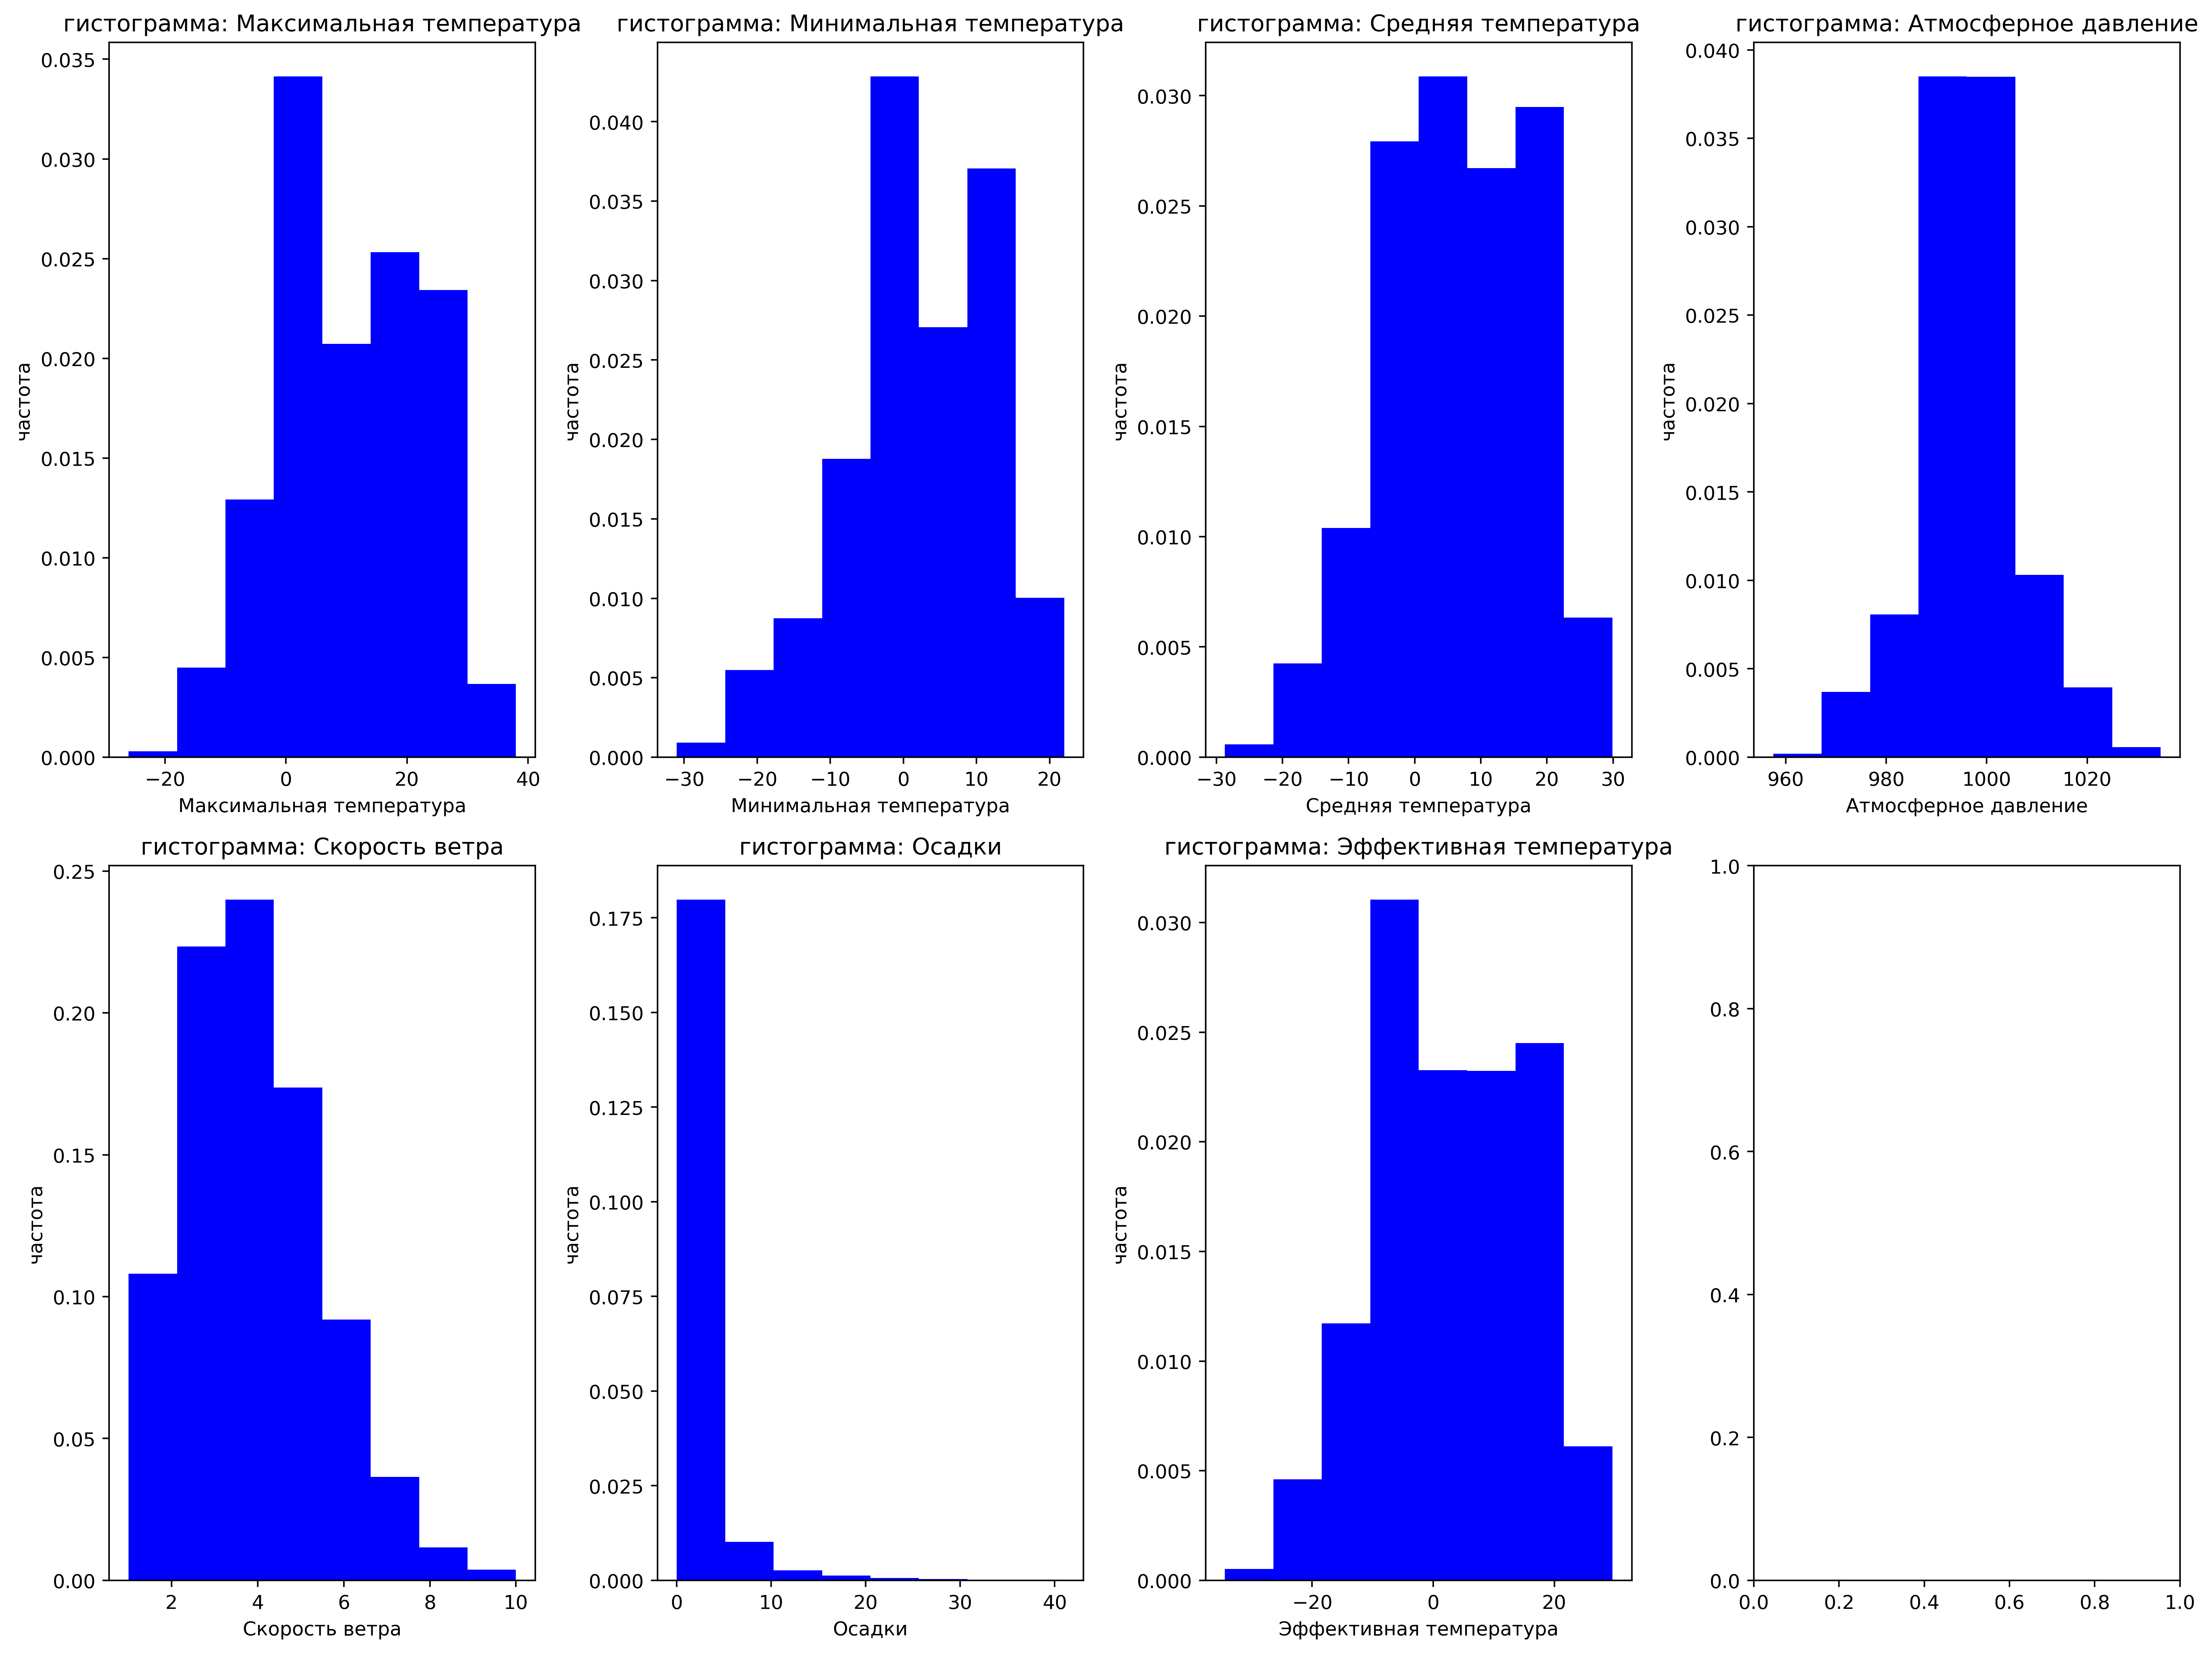

In [20]:
fig, axs = plt.subplots(2, 4, figsize=(16,12), dpi=400)
i = 0
for col in columns[1:]:
    now = axs[i//4, i%4]
    now.hist(df_all[col], color ='blue', bins = 8, density = True, align='mid')
    now.set_title('гистограмма: ' + col)
    now.set_ylabel('частота')
    now.set_xlabel(col);
    i += 1
fig.tight_layout()

По гистограммам отлично видно, что средняя температура в Москве чаще всего от 0-10 градусов по Цельсию, что отлично сочетается с наблюдениями о среднегодовой температуре 5.6 градусов. Осадков мало, почти всегда их нет, а вот ветер обычно есть, но небольшой - 1-2м/с. Атмосферное давление же соответсвует норме.

### *Средние величины*

In [27]:
df_avg_by_year = df_all.groupby(df_all["Дата"].dt.year).mean(numeric_only=True)
df_avg_by_year.head()

,Максимальная температура,Минимальная температура,Средняя температура,Атмосферное давление,Скорость ветра,Осадки,Эффективная температура
Дата,,,,,,,
2009,9.542192,1.309589,5.761644,996.789041,3.747945,2.043836,2.460822
2010,10.341096,1.287671,6.091781,997.438082,3.794521,1.679452,2.750685
2011,10.126027,2.076712,6.420822,996.465479,4.109589,1.682192,2.901370
2012,9.109563,1.303279,5.431694,997.208743,4.079235,2.245902,1.936885
2013,9.956164,2.219178,6.399726,995.432603,3.873973,2.506849,3.155890


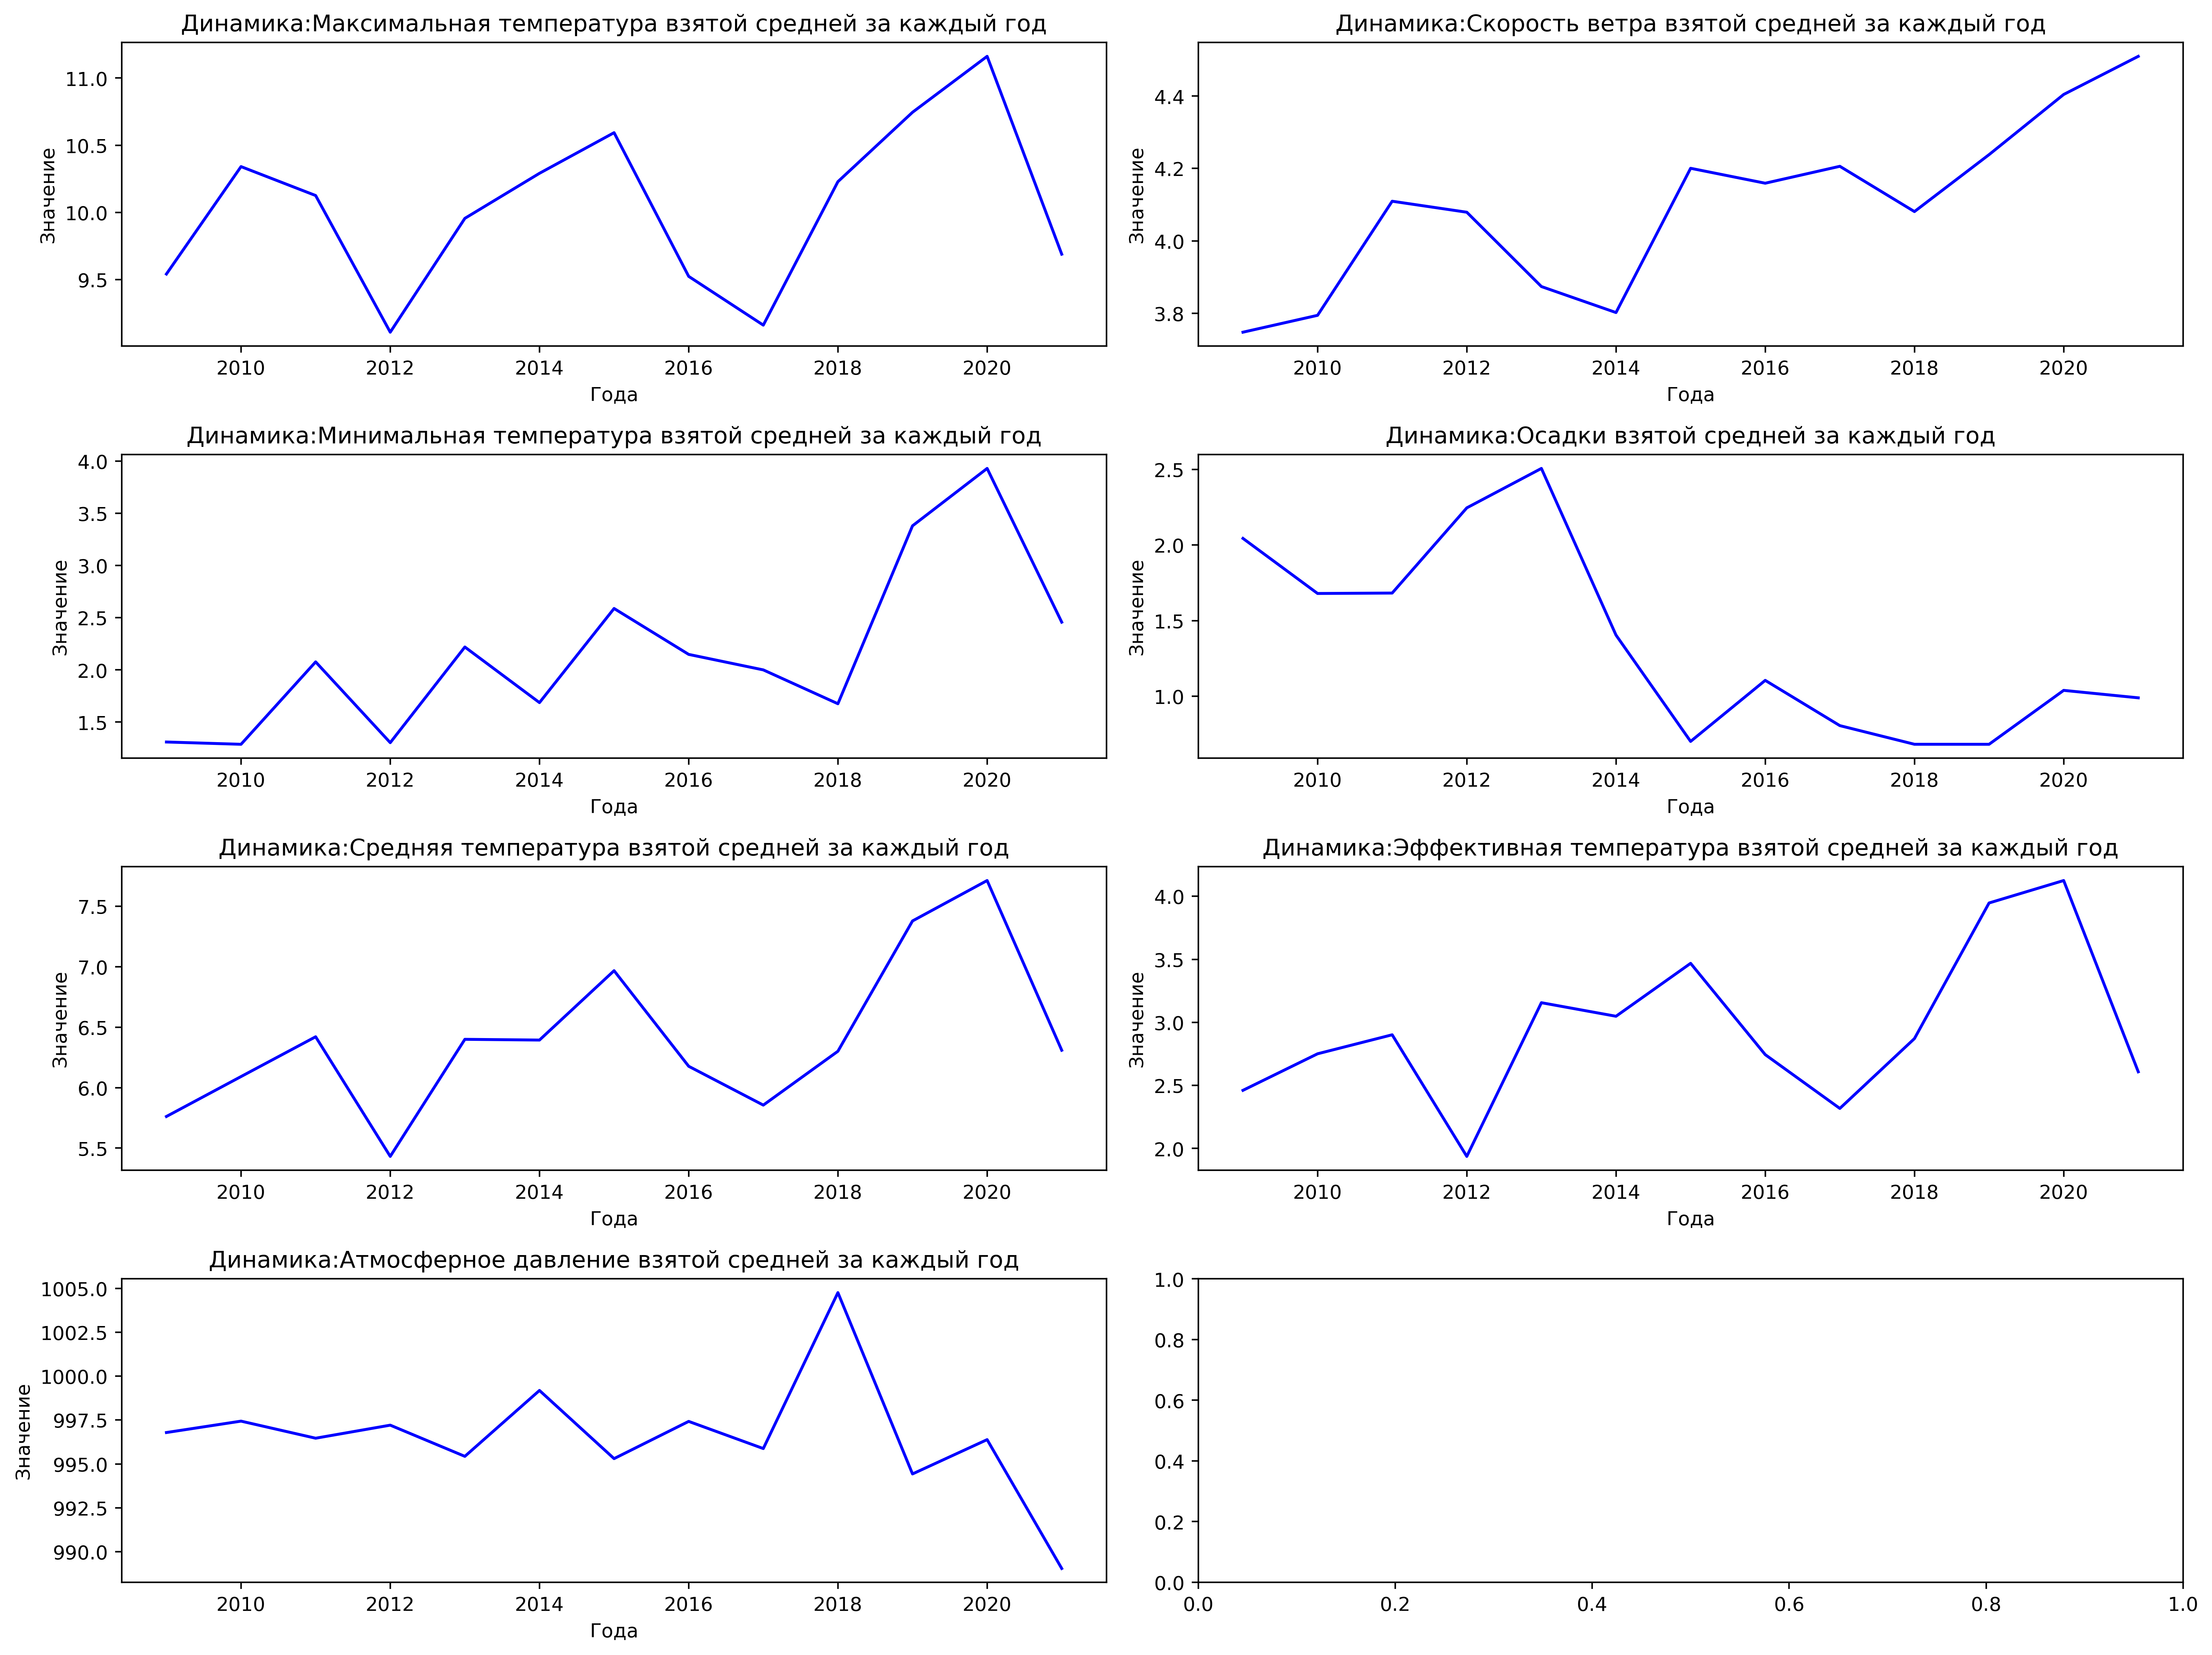

In [22]:
fig, axs = plt.subplots(4, 2, figsize=(16,12), dpi=400)
i = 0
for col in columns[1:]:
    now = axs[i%4, i//4]
    now.plot(df_avg_by_year[col], color ='blue')
    now.set_title('Динамика:' + col + ' взятой средней за каждый год')
    now.set_ylabel('Значение')
    now.set_xlabel('Года');
    i += 1
fig.tight_layout()

Из визуализации динамики температур в среднем можно заметить основную тенденцию к росту за весь рассматриваемый период, хоть и с небольшими флуктуациями

К 2021 году атмосферное давление в среднем достигает общепринятого нормального значения в 746-747 мм рт.ст. (995 бар = 746.3 мм рт.ст.)

### *Медиана*

In [24]:
df_med_by_year = df_all.groupby(df_all["Дата"].dt.year).median(numeric_only=True)
df_med_by_year.head()

,Максимальная температура,Минимальная температура,Средняя температура,Атмосферное давление,Скорость ветра,Осадки,Эффективная температура
Дата,,,,,,,
2009,8.0,2.0,5.7,997.0,4.0,0.0,1.3
2010,11.0,2.0,6.8,997.3,4.0,0.0,3.2
2011,9.0,2.0,5.8,996.0,4.0,0.0,2.1
2012,10.0,3.0,7.3,996.2,4.0,0.0,3.7
2013,9.0,2.0,6.1,995.5,4.0,0.0,2.7


### *Стандартное отклонение*

In [25]:
df_std_by_year = df_all.groupby(df_all["Дата"].dt.year).agg(np.std)
df_std_by_year.head()

,Максимальная температура,Минимальная температура,Средняя температура,Атмосферное давление,Скорость ветра,Осадки,Эффективная температура
Дата,,,,,,,
2009,11.283839,9.503906,10.237107,7.917500,1.458973,4.074613,11.588037
2010,14.559720,12.387160,13.377728,9.756215,1.513301,3.294808,14.911975
2011,12.595373,10.357597,11.317525,9.924330,1.444596,3.906579,12.792199
2012,12.786868,11.155113,11.973289,11.141121,1.363619,4.429004,13.547505
2013,11.704383,10.575795,10.774485,7.834269,1.420226,5.051720,12.384868


### *Дисперсия*

In [26]:
df_std_by_year.pow(2).head()

,Максимальная температура,Минимальная температура,Средняя температура,Атмосферное давление,Скорость ветра,Осадки,Эффективная температура
Дата,,,,,,,
2009,127.325028,90.324221,104.798360,62.686803,2.128602,16.602469,134.282609
2010,211.985449,153.441743,178.963614,95.183738,2.290080,10.855758,222.367012
2011,158.643414,107.279813,128.086378,98.492322,2.086858,15.261358,163.640355
2012,163.503990,124.436537,143.359650,124.124581,1.859458,19.616079,183.534882
2013,136.992579,111.847433,116.089533,61.375775,2.017040,25.519871,153.384945


In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(16,12), dpi=400)
i = 0
for col in columns[1:]:
    now = axs[i%4, i//4]
    now.plot(df_std_by_year[col], color ='blue')
    now.set_title('Дисперсия:' + col )
    now.set_ylabel('Дисперсия')
    now.set_xlabel('Года');
    i += 1
fig.tight_layout()

Неплохо видно, что хотя глобальное потепление предпологает рост дисперсии температуры (то есть рост размаха колебаний), ничего такого мы не наблюдаем


### Исходя из проведённого выше предварительного анализа, мы можем сформулировать следующие  гипотезы:
1. Температуру можно свести к какому-то из классических распределений
2. Каждый год средняя температура растет
3. Осень самая дождливая
4. Выходные в среднем более дождливые/холодные чем обычные дни (все же это замечали?)
5. Температура осенью ниже чем весной (иначе почему мы раздеваемя раньше?)
6. Статистически температура, когда есть осадки, ниже чем в другие дни

## Создание новых признаков - ШАГ 5

Создадим отдельные колонки в dataframe - сезон (зима/осень/весна/лето), булевые колонки (наличие осадков: 0-нет/1-да) и выходной ли данный день (суббота/воскресенье)

In [35]:
df_all["Осадки_b"] = df_all["Осадки"] > 0
'''
получаем сезон по номеру месяца
'''
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "Зима"
    if month in [3, 4, 5]:
        return "Весна"
    if month in [6, 7, 8]:
        return "Лето"
    if month in [9, 10, 11]:
        return "Осень" 
df_all["Сезон"] = df_all['Дата'].apply(get_season)

df_all['Выходной'] = df_all['Дата'].dt.dayofweek.isin([5, 6])

df_all.head()

,Дата,Максимальная температура,Минимальная температура,Средняя температура,Атмосферное давление,Скорость ветра,Осадки,Эффективная температура,Осадки_b,Сезон,Выходной
0,2009-01-01,-3.0,-9.0,-5.1,986.9,6.0,2.0,-11.2,True,Зима,False
1,2009-01-02,-8.0,-13.0,-11.0,989.0,6.0,0.0,-17.6,False,Зима,False
2,2009-01-03,-12.0,-14.0,-12.9,988.7,5.0,0.0,-19.0,False,Зима,True
3,2009-01-04,-12.0,-19.0,-15.1,988.2,3.0,1.0,-20.0,True,Зима,True
4,2009-01-05,-11.0,-17.0,-13.3,994.8,4.0,0.0,-18.8,False,Зима,False


Еще немного визуалиции
1. Гистограмма для каждого сезона

In [36]:
seasons = ['Зима', 'Весна', 'Лето', 'Осень']

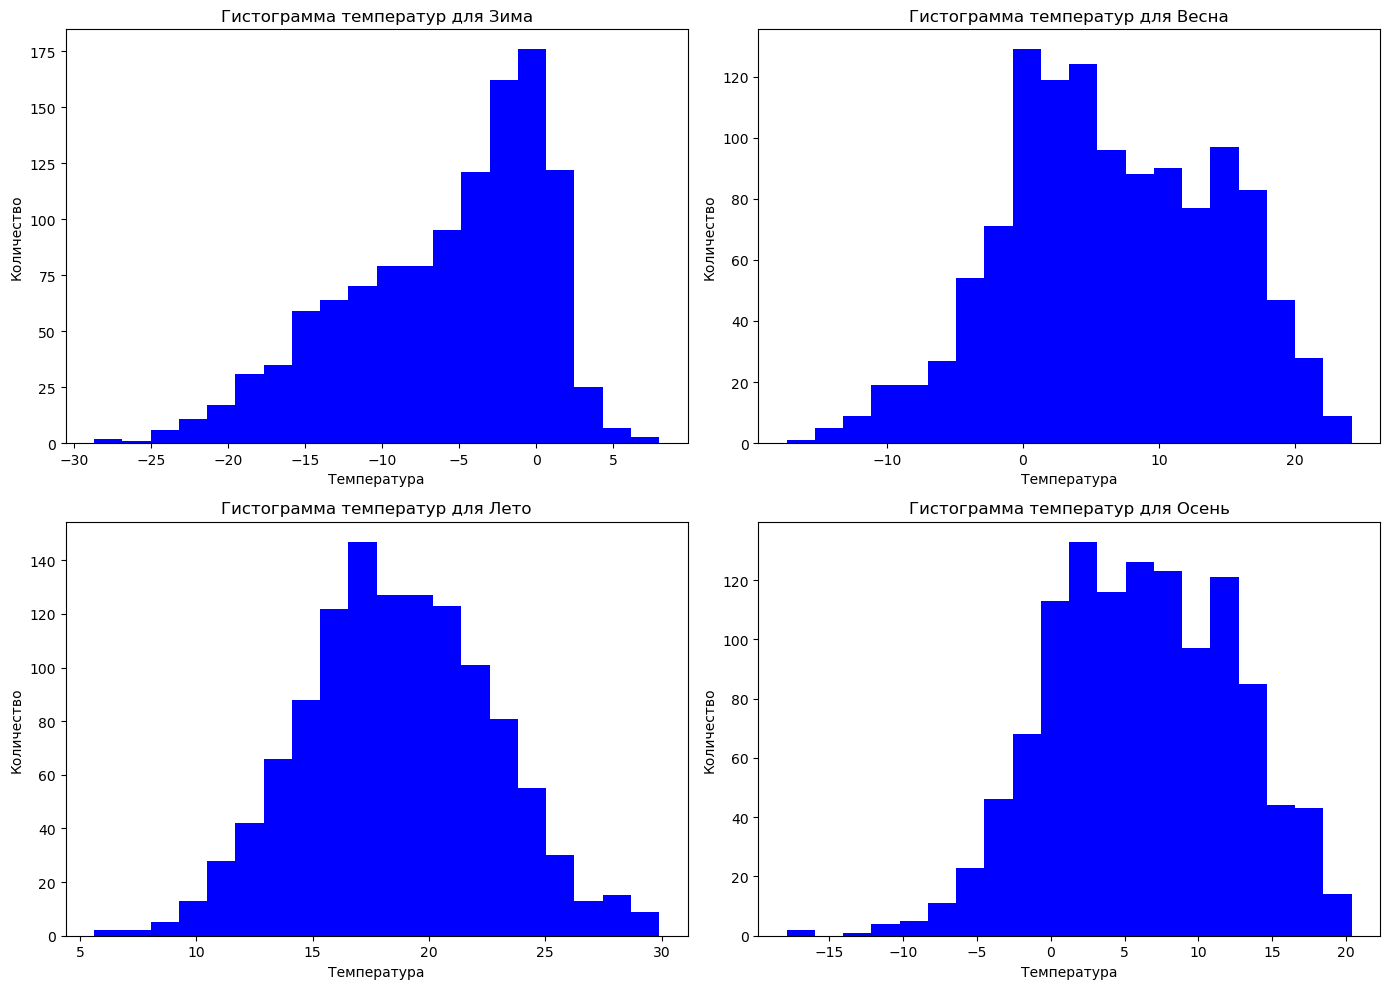

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(14,10))
i = 0
for season in seasons:
    now = axs[i//2, i%2]
    season_data = df_all[df_all['Сезон'] == seasons[i]]['Средняя температура']
    now.hist(season_data, color ='blue', bins=20)
    now.set_title('Гистограмма температур для ' + season)
    now.set_ylabel('Количество')
    now.set_xlabel('Температура');
    i += 1
fig.tight_layout()

2. Ящики с усами для каждого сезона

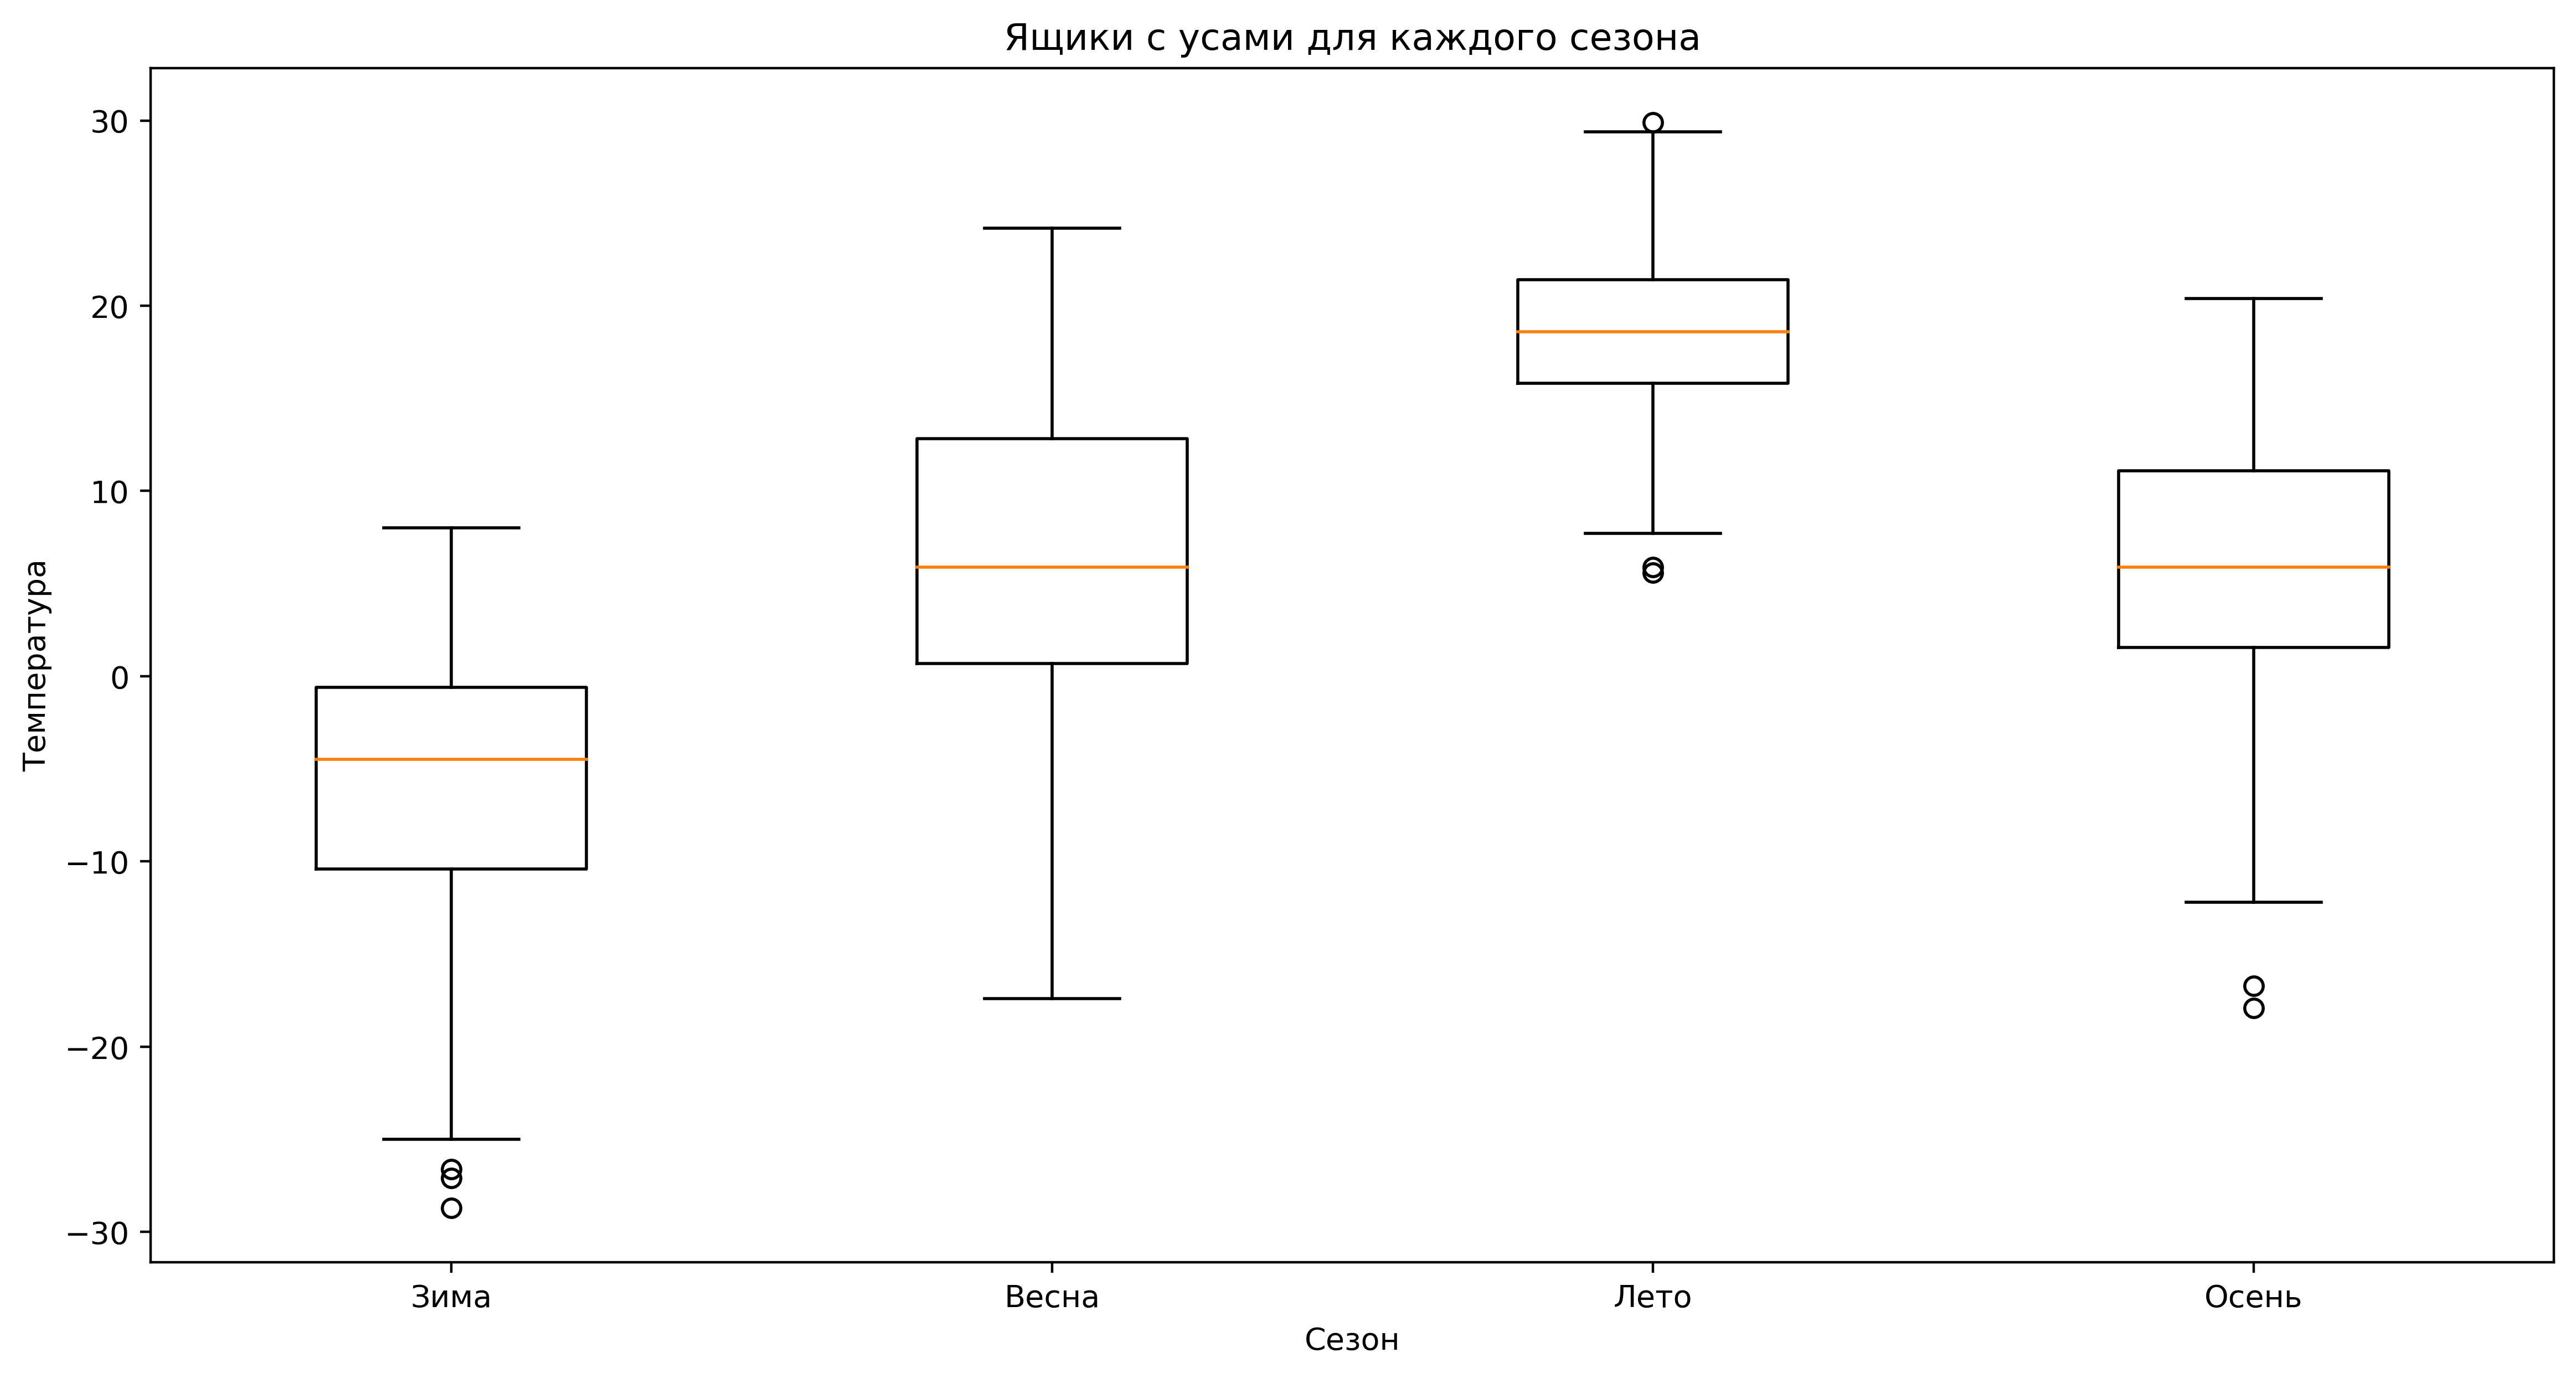

In [38]:
seasons = ['Зима', 'Весна', 'Лето', 'Осень']
box_data = []
fig, axs = plt.subplots(1, 1, figsize=(14,7), dpi=400)
for i in range(4):
    season_data = df_all[df_all['Сезон'] == seasons[i]]['Средняя температура']
    # Добавляем данные в список
    box_data.append(season_data)
 # Строим ящики с усами
axs.boxplot(box_data, labels=seasons)

# Добавляем заголовок и подписи осей
axs.set_title('Ящики с усами для каждого сезона')
axs.set_xlabel('Сезон')
axs.set_ylabel('Температура')

# Отображаем график
plt.show()   

Хорошо видно, что выбросов в данных немного, однако данные довольно сильно распределены, сам ящик довольно узкий, значит половина наблюдений лежит довольно узко в каждом сезоне (около 10 градусов), а летом около пяти

Также видно, что в целом распределние температур по сезонам довольно логичное и осень примерно такая же теплая, как и весна, а лето теплее всего, тогда, как зима холоднее

Также видно, что медиана несимметрична и иногда довольно сильно. О чём это говорит в контексте данных погоды, мы сами не знаем, но можем лишь предполагать на основе этого примерный вид графика распределения.

3. Количество дожлидвых дней в каждом сезоне - гистограммы (да, мы любим гистограммы)

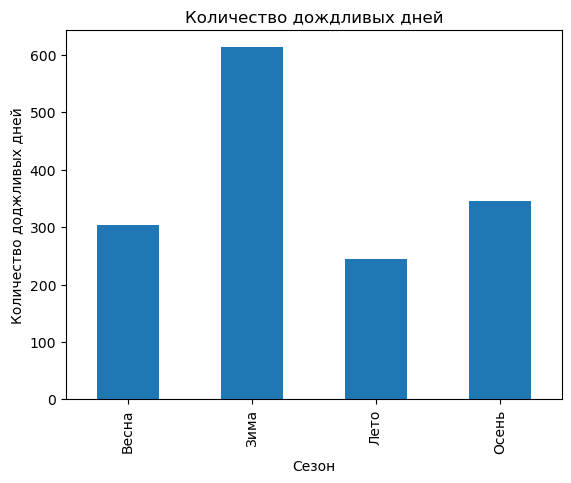

In [39]:
osadki = df_all.groupby(df_all["Сезон"]).sum()["Осадки_b"]
osadki.plot.bar()

# Добавляем заголовок и подписи осей
plt.title('Количество дождливых дней')
plt.xlabel('Сезон')
plt.ylabel('Количество доджливых дней');

## Подтверждение / опровержение гипотез - ШАГ 6

Ещё раз гипотезы
1. Температуру можно свести к какому-то из классических распределений
2. Каждый год средняя температура растет относительно базисного 2009
3. Осень самая дождливая
4. Выходные в среднем более дождливые/холодные чем обычные дни (все же это замечали?)
5. Температура осенью ниже чем весной (иначе почему мы раздеваемя раньше?)
6. Статически температура, когда есть осадки, ниже чем в другие дни

#### Гипотеза 1
Выше мы явно видели, что гистограмма температуры за все дни явно имеет два (может три) пика, что сразу отметает возможность того, что это классическое нормальное распределение; иными словами, из рассмотрения гипотезы убираются случаи сведения данных к распределению с одной вершиной на гистограмме

Проверим те, что теоритечески подходят!

Проверим на нормальность

In [40]:
data = df_all["Средняя температура"]

In [41]:
# Выполняем тест на нормальность с помощью sts.normaltest
_, p_value = sts.normaltest(data)
print(p_value)
# Проверяем гипотезу о нормальности
alpha = 0.05
if p_value < alpha:
    print("Данные не соответствуют нормальному распределению.")
else:
    print("Данные соответствуют нормальному распределению.")

1.5181702071149341e-46
Данные не соответствуют нормальному распределению.


Мы не могли не попробовать... 

распределение Стьюдента

In [42]:
# Выполняем тест на соответствие распределению Стьюдента
t_params = sts.t.fit(data)

# Проверяем гипотезу о соответствии распределению Стьюдента
alpha = 0.05
t_p_value = sts.kstest(data, 't', args=sts.t.fit(data)).pvalue
print(t_p_value)
if t_p_value < alpha:
    print("Данные не соответствуют распределению Стьюдента.")
else:
    print("Данные соответствуют распределению Стьюдента.")

3.0618202246029597e-18
Данные не соответствуют распределению Стьюдента.


In [28]:
# Оцениваем параметры смеси нормальных распределений(почти третья домашка, только не logreg а GaussianMixture
# (смесь нормальных распрелений)
gmm = GaussianMixture(n_components=2, random_state=rnd_seed)  # Задаем количество компонентов (пиков)
gmm.fit(data.values.reshape(-1, 1))

alpha = 0.05

kstest_result = sts.kstest(data.values.reshape(-1, 1).flatten(), gmm.sample(len(data))[0].flatten())

print(kstest_result.pvalue)
if kstest_result.pvalue < alpha:
    print("Данные не соответствуют смеси двух нормальных распределений.")
else:
    print("Данные соответствуют смеси  двух нормальных распределений.")

0.00016240141386660172
Данные не соответствуют смеси двух нормальных распределений.


Возможно было три пика?

In [31]:
# Оцениваем параметры смеси нормальных распределений(почти третья домашка, только не logreg а GaussianMixture
# (смесь нормальных распрелений)
gmm = GaussianMixture(n_components=3, random_state=rnd_seed)  # Задаем количество компонентов (пиков)
gmm.fit(data.values.reshape(-1, 1))

alpha = 0.05
sample = gmm.sample(len(data))[0].flatten()
kstest_result = sts.kstest(data.values.reshape(-1, 1).flatten(), sample)

print(kstest_result.pvalue)
if kstest_result.pvalue < alpha:
    print("Данные не соответствуют смеси трех нормальных распределений.")
else:
    print("Данные соответствуют смеси трех нормальных распределений.")

0.4001586688033985
Данные соответствуют смеси трех нормальных распределений.


Получилось!

Теперь сравним распределения 

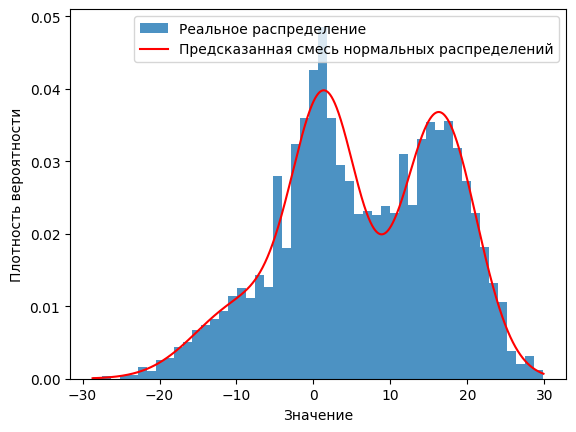

In [32]:
# Построение гистограммы для данных
plt.hist(data, bins=50, density=True, alpha=0.8, label='Реальное распределение')

# Построение графика плотности вероятности для предсказанной смеси трех нормальных распределений
x = np.linspace(data.min(), data.max(), 5000)
pdf = np.sum([w * sts.norm.pdf(x, mu, sigma) for w, mu, sigma in zip(gmm.weights_, gmm.means_, np.sqrt(gmm.covariances_))], axis=0)
plt.plot(x, pdf.flatten(), 'r-', label='Предсказанная смесь нормальных распределений')

plt.xlabel('Значение')
plt.ylabel('Плотность вероятности')
plt.legend(loc="best")

plt.show()

Действительно, видно довольно неплохое совпадение предсказаного распределения и гистограммы реальных данных. 

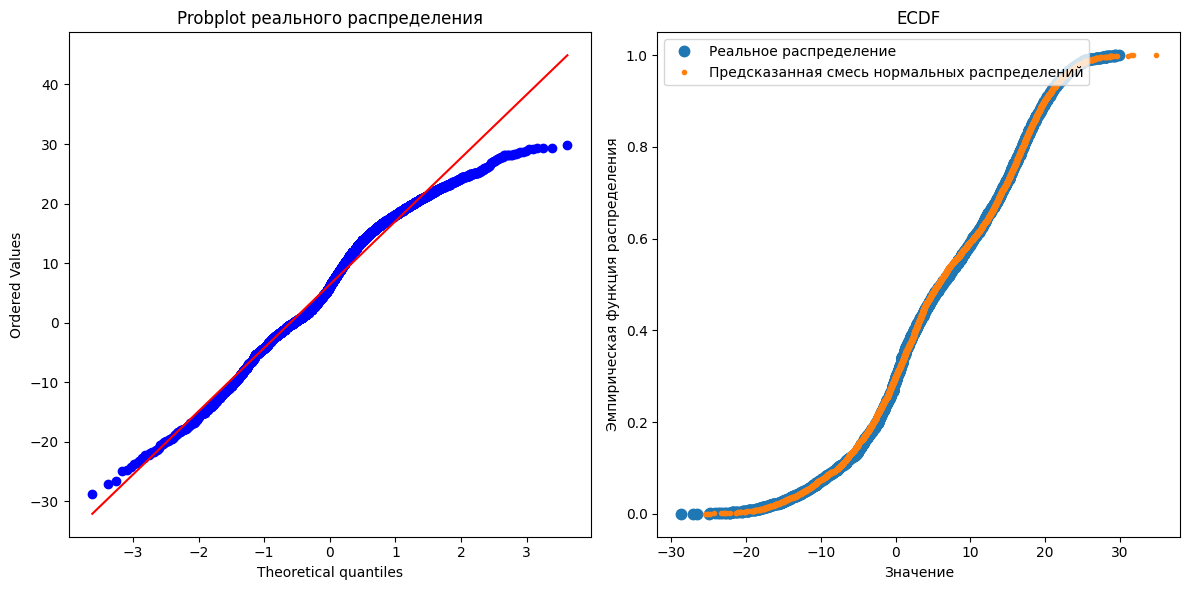

In [33]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# График probplot
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
res = stats.probplot(data, plot=plt)
plt.title('Probplot реального распределения')

# График ECDF
plt.subplot(122)
x = np.sort(data)
y = np.arange(1, len(data) + 1) / len(data)
plt.plot(x, y, marker='.', linestyle='none', label='Реальное распределение', markersize=15)

# Вычисляем и строим ECDF для предсказанного распределения
gmm_samples = gmm.sample(len(data))[0].flatten()
gmm_x = np.sort(gmm_samples)
gmm_y = np.arange(1, len(gmm_samples) + 1) / len(gmm_samples)
plt.plot(gmm_x, gmm_y, marker='.', linestyle='none', label='Предсказанная смесь нормальных распределений')

plt.title('ECDF')
plt.xlabel('Значение')
plt.ylabel('Эмпирическая функция распределения')
plt.legend()

plt.tight_layout()
plt.show()


Сообсвтенно и тут мы видим почти идеально совпадение - единственное, верхний хвост на problot куда-то уехал, что видно и на гистограмме. 

#### Гипотеза 2

Проверим что температура каждый год в среднем растет

Для проверки статистической значимости тренда в средних значениях температуры за каждый год, можно использовать тест Спирмена.

In [57]:
# Вычисляем ранговый коэффициент корреляции Спирмена и его p-значение
corr, p_value = sts.spearmanr(df_avg_by_year.index, df_avg_by_year['Средняя температура'])

alpha = 0.05  # Уровень значимости
print("corr:{}, p_value:{}".format(corr, p_value))
if p_value < alpha:
    print("Средняя температура имеет статистически значимый тренд")
else:
    print("Средняя температура не имеет статистически значимого тренда")

corr:0.45604395604395603, p_value:0.11728306543614495
Средняя температура не имеет статистически значимого тренда


Коэффицент положительный, однако средняя температура на конкретно московской выборке за 13 лет не имеет статистически значимого тренда. 

#### Гипотеза 3 
Проверим, что каждый год осень дождливее сезона; предполагаем, что зимой температура минусовая, и дождя чисто физически не будет.

Мы используем метод groupby для группировки данных по годам и сезонам, а затем вычисляем среднее количество дождливых дней для каждого года и сезона. Затем мы фильтруем данные для осени, лета и весны и применяем t-тест (ttest_ind) для сравнения средних значений дождливых дней между осенью и другими сезонами (летом и весной). Если p-значение меньше заданного уровня значимости alpha, то мы делаем вывод, что осень статистически более дождлива, чем лето или весна.

In [35]:
# Ограничение данных только годами до 2013
df_filtered = df_all
# Извлечение года из колонки с датой
df_filtered['Год'] = df_filtered['Дата'].dt.year
# Группировка данных по годам и сезонам и вычисление среднего количества дождливых дней
df_grouped = df_filtered.groupby(['Год', 'Сезон']).mean(numeric_only=True)['Осадки_b'].reset_index()

In [36]:
# Фильтрация данных для осени, лета и весны
autumn_data = df_grouped[df_grouped['Сезон'] == 'Осень']['Осадки_b']
summer_data = df_grouped[df_grouped['Сезон'] == 'Лето']['Осадки_b']
spring_data = df_grouped[df_grouped['Сезон'] == 'Весна']['Осадки_b']

# Применение t-теста для сравнения средних значений дождливых дней
t_statistic, p_value = sts.ttest_ind(autumn_data, summer_data, alternative="greater")
alpha = 0.05  # Уровень значимости
print(p_value)
if p_value < alpha:
    print("Осень статистически более дождлива, чем лето")
else:
    print("Нет статистической значимости в различии между осенью и летом")

t_statistic, p_value = sts.ttest_ind(autumn_data, spring_data, alternative="greater")
print(p_value)
if p_value < alpha:
    print("Осень статистически более дождлива, чем весна")
else:
    print("Нет статистической значимости в различии между осенью и весной")

0.09878709993829869
Нет статистической значимости в различии между осенью и летом
0.25773237401927174
Нет статистической значимости в различии между осенью и весной


Видим, что хоть осень и можно считать более дожлидовой, чем лето, но только уровне значимости 10%. С весной же вообще только на 26%. Возможно, дело в том, что в данных по осадкам и давлению с другой станции слишком много пропусков, которые мы радостно заполнили 0

#### Гипотеза 4
Выходные в среднем более дождливые/холодные, чем обычные дни (все же это замечали?)

In [37]:
import pandas as pd
from scipy.stats import ttest_ind

# Разделение данных на выходные и обычные дни
df_weekend = df_all[df_all['Выходной'] == True]
df_weekday = df_all[df_all['Выходной'] == False]

# Получение колонок "Осадки_b" и "Средняя температура"
precipitation_weekend = df_weekend['Осадки_b']
temperature_weekend = df_weekend['Средняя температура']

precipitation_weekday = df_weekday['Осадки_b']
temperature_weekday = df_weekday['Средняя температура']

# Выполнение t-теста для сравнения средних значений
t_statistic_precipitation, p_value_precipitation = ttest_ind(precipitation_weekend, precipitation_weekday, alternative="greater")
t_statistic_temperature, p_value_temperature = ttest_ind(temperature_weekend, temperature_weekday, alternative="less")

alpha = 0.05  # Уровень значимости
print(p_value_precipitation)
if p_value_precipitation < alpha:
    print("Выходные дни статистически более дождливые, чем обычные дни")
else:
    print("Нет статистической значимости в различии между выходными и обычными днями по осадкам")
print(p_value_temperature)
if p_value_temperature < alpha:
    print("Выходные дни статистически холоднее, чем обычные дни")
else:
    print("Нет статистической значимости в различии между выходными и обычными днями по температуре")


0.15658488055650438
Нет статистической значимости в различии между выходными и обычными днями по осадкам
0.5896446456919752
Нет статистической значимости в различии между выходными и обычными днями по температуре


Кто бы сомневался - это всего лишь когнитивная ошибка нашего мозга. Мы заостряем наше внимание на плохой погоде (особенно в выходные), а хорошую принимаем за данность

#### Гипотеза 5
Температура осенью ниже, чем весной (иначе почему мы раздеваемся раньше?)

In [38]:
# Фильтрация данных для осени и весны
autumn_data = df_all[df_all['Сезон'] == 'Осень']['Средняя температура']
spring_data = df_all[df_all['Сезон'] == 'Весна']['Средняя температура']

# Выполнение t-теста для сравнения средних значений
t_statistic, p_value = ttest_ind(autumn_data, spring_data, alternative="less")

alpha = 0.05  # Уровень значимости
print(p_value)
if p_value < alpha:
    print("Температура осенью статистически ниже, чем весной")
else:
    print("Нет статистической значимости в различии между температурой осени и весны")

0.16531957499818117
Нет статистической значимости в различии между температурой осени и весны


И снова мимо..

#### Гипотеза 6
Статически температура, когда есть осадки, ниже, чем в другие дни

Не будем забывать, что осадки чаще идут как раз в более холодные времена года, поэтому разделим данные на сезоны (а лучше было бы на месяцы, but it is what it is...)

In [39]:
seasons = ['Осень', 'Весна', 'Зима', 'Лето']
alpha = 0.05  # Уровень значимости

for season in seasons:
    season_data = df_all[df_all['Сезон'] == season]
    temp_with_precipitation = season_data[season_data['Осадки_b'] == True]['Средняя температура']
    temp_without_precipitation = season_data[season_data['Осадки_b'] == False]['Средняя температура']
    
    t_statistic, p_value = ttest_ind(temp_with_precipitation, temp_without_precipitation, alternative="less")
    
    if p_value < alpha:
        print(f"Температура в сезоне {season} при наличии осадков статистически ниже, чем без осадков.")
    else:
        print(f"Статистически значимых различий в температуре в сезоне {season} с осадками и без осадков не обнаружено.")


Температура в сезоне Осень при наличии осадков статистически ниже, чем без осадков.
Температура в сезоне Весна при наличии осадков статистически ниже, чем без осадков.
Статистически значимых различий в температуре в сезоне Зима с осадками и без осадков не обнаружено.
Температура в сезоне Лето при наличии осадков статистически ниже, чем без осадков.


Отлично - подтверждается то, что в Москве контитентальный климат, то есть осадки зимой повышают температуру, а не понижают, тогда как в остальные времена года наоборот. Собственно, мы все замечали, что со снегом морозы мягче, а в солненчную погоду зимой холоднее (приходит холодный антициклон - так устроен наш климат)

Проверим, что зимой температура наоборот выше

In [40]:
season_data = df_all[df_all['Сезон'] == "Зима"]
temp_with_precipitation = season_data[season_data['Осадки_b'] == True]['Средняя температура']
temp_without_precipitation = season_data[season_data['Осадки_b'] == False]['Средняя температура']

ttest_ind(temp_with_precipitation, temp_without_precipitation, alternative="greater")
if p_value < alpha:
    print(f"Температура зимой при наличии осадков статистически выше, чем без осадков.")
else:
     print(f"Статистически значимых различий в температуре зимой с осадками и без осадков не обнаружено.")

Температура зимой при наличии осадков статистически выше, чем без осадков.


И тут победа - континентальный климат в Москве подтвержден :)))

## Машинное обучение - ШАГ 7 

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import precision_recall_curve

Разделим данные на обучающие и тестовые. В качестве массива данных X_train будем использовать таблицу, где колонки - 14 последних дней по температуре и осадкам. Создадим таблицу, где Y_train как данные о средней температуре 2009-2019, а X_train как 14 колонок с температурой за предыдущие 14 дней соответсвующие дню Y_train, и 14 колонок с осадками за предыдущие 14 дней. Также в X_train сохраним сезон дня

In [42]:
'''
Функция для создания колонок с предыдущими значениями температуры и осадков
'''
def create_previous_columns(data, column_name, num_prev_days):
    columns = []
    for i in range(1, num_prev_days + 1):
        col_name = f"{column_name}_prev_{i}"
        data[col_name] = data[column_name].shift(i)
        columns.append(col_name)
    return columns

'''
Функция для получения данных о температуре и осадках за предыдущие days, и таблицы с данными из колонки find_col 
с таким же количеством строчек, каждому из которых соответсвует строчка в X_train с предыдущими данными
'''
def divide_on(train_data, days, find_col):
    # Создание колонок с предыдущими значениями температуры и осадков
    temperature_columns = create_previous_columns(train_data, 'Средняя температура', days)
    precipitation_columns = create_previous_columns(train_data, 'Осадки_b', days)
    season_data = train_data["Сезон"]

    # Создание таблицы X_train с предыдущими значениями температуры и осадков
    X_train = train_data[temperature_columns + precipitation_columns]
    # Добавление колонки сезона в X_train
    X_train['Месяц'] = train_data['Дата'].dt.month
    X_train[find_col] = train_data[find_col]
    
    # Удаление строк с пропущенными значениями
    X_train.dropna(inplace=True)
    # Создание таблицы Y_train с данными о средней температуре
    Y_train = X_train[[find_col]].copy()
    # Удаление колонки "Средняя температура" из X_train
    X_train.drop(find_col, axis=1, inplace=True)
    
    
    return X_train, Y_train

# Выделение данных за 2009-2019 годы
train_data = df_all[df_all['Дата'].dt.year < 2019]

X_train, Y_train = divide_on(train_data, 14, "Средняя температура")

# Выделение данных за 2009-2019 годы
test_data = df_all[df_all['Дата'].dt.year >= 2019]

X_test, Y_test = divide_on(test_data, 14, "Средняя температура")

Используем RandomForestRegressor для предсказания средней температуры, потому что он является мощным алгоритмом машинного обучения, основанным на ансамбле решающих деревьев.

Вот несколько причин, почему RandomForestRegressor хорошо подходит для данной задачи:

Гибкость модели: RandomForestRegressor способен моделировать сложные нелинейные зависимости между входными признаками и целевой переменной. Он способен автоматически обнаруживать и учитывать нелинейные взаимодействия между признаками, что может быть полезно при предсказании температуры.

Устойчивость к выбросам: RandomForestRegressor показывает хорошую устойчивость к выбросам в данных. Он работает путем усреднения прогнозов нескольких деревьев, что может снижать влияние выбросов на итоговый прогноз.

Автоматический отбор признаков: RandomForestRegressor способен оценивать важность признаков и автоматически выбирать наиболее информативные для предсказания целевой переменной. Это может быть полезным при работе с большим количеством признаков.

Снижение переобучения: RandomForestRegressor имеет встроенные механизмы для снижения переобучения, такие как случайное выборка признаков и случайное выборка обучающих данных для каждого дерева. Это помогает предотвратить переобучение модели и обеспечить ее обобщающую способность.

Возможность работы с различными типами признаков: RandomForestRegressor способен обрабатывать как числовые, так и категориальные признаки без дополнительной предобработки данных.

Все эти преимущества делают RandomForestRegressor хорошим выбором для задачи предсказания средней температуры на основе исторических данных.

In [43]:
# Создание и обучение модели
model = RandomForestRegressor(random_state=rnd_seed)
model.fit(X_train, Y_train)

 # Предсказание на обучающих данных
train_predictions = model.predict(X_train)
train_mae = mean_absolute_error(Y_train, train_predictions)
train_r2 = r2_score(Y_train, train_predictions)
print("MAE на обучающих данных:", train_mae)
print("R-squared на обучающих данных:", train_r2)

# Предсказание на тестовых данных
test_predictions = model.predict(X_test)
test_mae = mean_absolute_error(Y_test, test_predictions)
test_r2 = r2_score(Y_test, test_predictions)
print("MAE на тестовых данных:", test_mae)
print("R-squared на тестовых данных:", test_r2)

MAE на обучающих данных: 0.7340904578047435
R-squared на обучающих данных: 0.9919949839664656
MAE на тестовых данных: 1.9655651769087525
R-squared на тестовых данных: 0.9315804018183641


Значения MAE (Mean Absolute Error) и R-squared на тестовых данных используются для оценки качества модели предсказания средней температуры.

MAE измеряет среднюю абсолютную разницу между фактическими и предсказанными значениями температуры. Значение MAE равное 1.9747 означает, что средняя абсолютная разница между фактическими и предсказанными значениями составляет около 1.97 градусов по выбранной единице измерения. Чем меньше значение MAE, тем лучше модель.

R-squared (коэффициент детерминации) измеряет долю объясненной дисперсии моделью относительно общей дисперсии целевой переменной. Значение R-squared равное 0.9320 означает, что модель объясняет около 93.20% дисперсии в данных температуры. Значение R-squared близкое к 1 указывает на хорошую соответствие модели данным.

Такие значения MAE и R-squared на тестовых данных говорят о том, что модель достаточно точно предсказывает среднюю температуру с небольшой средней абсолютной ошибкой и высоким коэффициентом детерминации.

Немножко визуализации (все как мы любим))

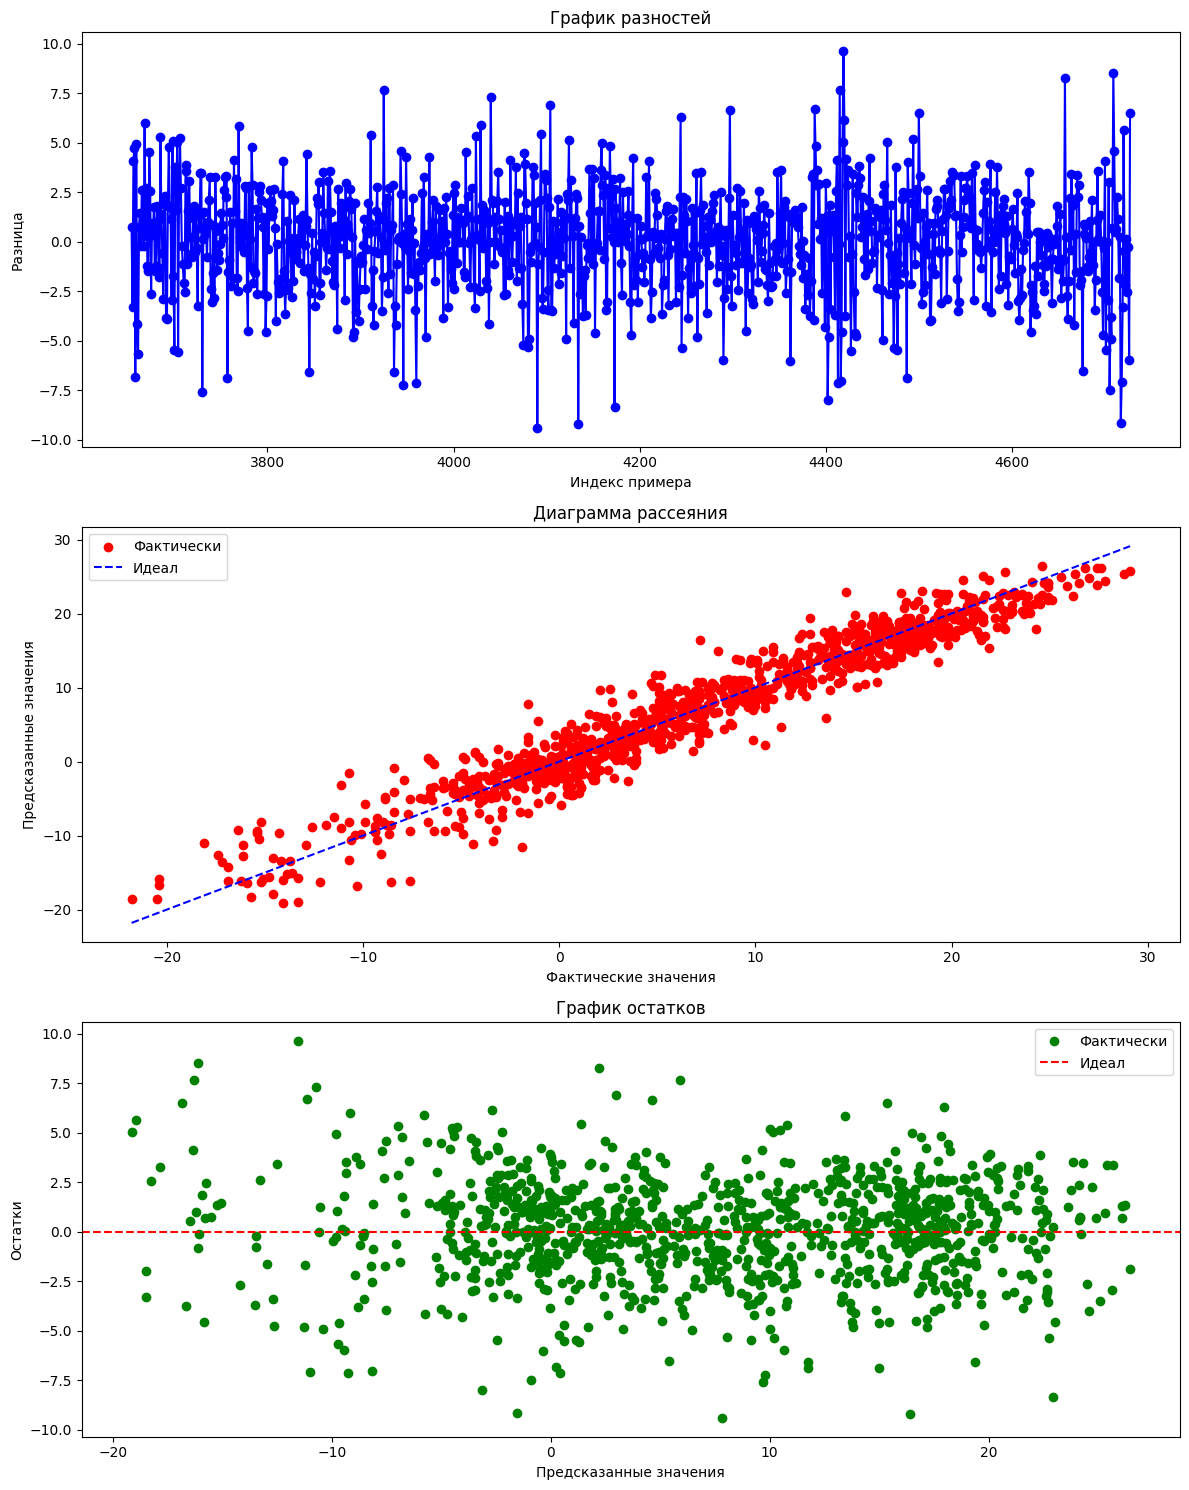

In [44]:
import matplotlib.pyplot as plt
Y_pred = test_predictions.reshape(-1, 1)
# Вычисление разностей между предсказанными значениями и фактическими значениями
differences = Y_test - Y_pred

# Создание фигуры с двумя подграфиками
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

# График разностей
ax1.plot(differences, marker='o', linestyle='-', color='blue')
ax1.set_xlabel('Индекс примера')
ax1.set_ylabel('Разница')
ax1.set_title('График разностей')

# Диаграмма рассеяния
ax2.scatter(Y_test, Y_pred, marker='o', color='red', label="Фактически")
ax2.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], linestyle='--', color='blue', label="Идеал")
ax2.set_xlabel('Фактические значения')
ax2.set_ylabel('Предсказанные значения')
ax2.set_title('Диаграмма рассеяния')
ax2.legend()
# График остатков
residuals = differences
ax3.plot(Y_pred, residuals, marker='o', linestyle='', color='green', label="Фактически")
ax3.axhline(y=0, color='red', linestyle='--', label="Идеал")
ax3.set_xlabel('Предсказанные значения')
ax3.set_ylabel('Остатки')
ax3.set_title('График остатков')
ax3.legend()
# Отображение графиков
plt.tight_layout()
plt.show()


Теперь предскаждем дожди! Исходные данные - те же, но предсказываем теперь булевую переменную осадки


In [45]:
# Выделение данных за 2009-2019 годы
train_data = df_all[df_all['Дата'].dt.year < 2019]

X_train, Y_train = divide_on(train_data, 14, "Осадки_b")

# Выделение данных за 2009-2019 годы
test_data = df_all[df_all['Дата'].dt.year >= 2019]

X_test, Y_test = divide_on(test_data, 14, "Осадки_b")

In [46]:
'''
Функция для оценки модели и вывода 4х основных параметров
'''
def score_model(model, threshold = 0.5):
    # Получаем предсказания вероятностей первого класса для тестовых данных
    test_predictions = model.predict_proba(X_test)[:, 1]
    test_predictions

    test_preds = (test_predictions >= threshold).astype(int)

    # Считаем метрики
    roc_auc = roc_auc_score(Y_test, test_predictions)
    accuracy = accuracy_score(Y_test, test_preds)
    precision = precision_score(Y_test, test_preds)
    recall = recall_score(Y_test, test_preds)

    # Выводим результаты
    print('ROC-AUC:', roc_auc)
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)

In [47]:
# Создание и обучение модели случайного леса
model = RandomForestClassifier(n_jobs=-1, random_state=rnd_seed)
model.fit(X_train, Y_train)

score_model(model)

ROC-AUC: 0.820078666236586
Accuracy: 0.7970204841713222
Precision: 0.5853658536585366
Recall: 0.4743083003952569


Плохо, идём по-другому, попробуем поиграться с параметрами

In [48]:
# Создание экземпляра модели RandomForestClassifier
model = RandomForestClassifier(n_jobs=-1, random_state=42)

# Определение гиперпараметров, которые будут подбираться
param_grid = {
    'n_estimators': [100, 200, 300],  # Количество деревьев в лесу
    'max_depth': [None, 5, 10],  # Максимальная глубина деревьев
    'min_samples_split': [2, 5, 10],  # Минимальное число образцов для разделения узла
    'min_samples_leaf': [1, 2, 4],  # Минимальное число образцов в листовом узле
    'max_features': ['sqrt', 'log2', None],  # Количество признаков для поиска наилучшего разделения
    'bootstrap': [True, False],  # Использование или нет подвыборки при построении деревьев
}

# Создание объекта RandomizedSearchCV
random_search = GridSearchCV(
    model,
    param_grid,
    cv=4,
    scoring='roc_auc',  # Метрика для оценки качества модели
    n_jobs=-1,
)
# если ставите refit = True, готовьтесь ждать кучу времени пока модель переподберет параметры! На мощном компе - 4 минуты
refit = False
if refit:
    # Обучение модели на данных X_train, Y_train
    random_search.fit(X_train, Y_train.values.ravel())

    # Вывод наилучших параметров модели
    print("Best parameters:", random_search.best_params_)
    
    best_params = random_search.best_params_
else:
    best_params = {'bootstrap': True, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}


# Создание и обучение модели случайного леса
model = RandomForestClassifier(n_jobs=-1, random_state=rnd_seed, **best_params)
model.fit(X_train, Y_train)

score_model(model)

ROC-AUC: 0.8389171597348264
Accuracy: 0.8119180633147114
Precision: 0.6040816326530613
Recall: 0.5849802371541502


logreg must suffer of course, но мы поиграемся и с ним)

In [49]:
logreg = LogisticRegression(random_state=42)

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 200],
    'fit_intercept': [True, False],
    'class_weight': ['balanced', None],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100],
    'multi_class': ['auto', 'ovr', 'multinomial']
}

# если ставите refit = True, готовьтесь ждать кучу времени пока модель переподберет параметры! На мощном компе - 2 минуты
refit = False
if refit:
    grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, Y_train.values.ravel())
    best_params = grid_search.best_params_
    print("Best parameters: ", grid_search.best_score_)
else:
    best_params = {'C': 10, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'l2',
                   'solver': 'lbfgs'}

print("Best parameters: ", best_params)

Best parameters:  {'C': 10, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs'}


Оценим качество лучшей модели - recall хоть как-то ожил, по остальным тоже прирост. В целом - чуть лучше)

In [50]:
model = LogisticRegression(random_state=42, **best_params)
model.fit(X_train, Y_train)
score_model(model)

ROC-AUC: 0.8444247591628835
Accuracy: 0.8016759776536313
Precision: 0.564935064935065
Recall: 0.6877470355731226


Данные метрики говорят о следующем:

ROC-AUC (Area Under the Receiver Operating Characteristic Curve) - это метрика, которая измеряет качество модели классификации. Значение ROC-AUC, равное 0.8446, говорит о том, что модель имеет хорошую способность разделять классы (наличие и отсутствие осадков) и хорошо работает на тестовых данных.

Accuracy (точность) - это метрика, которая измеряет долю правильных предсказаний модели относительно общего числа предсказаний. Значение Accuracy, равное 0.8017, означает, что модель правильно классифицировала около 80% данных на тестовой выборке.

Precision (точность) - это метрика, которая измеряет долю правильно предсказанных положительных классов (наличие осадков) относительно всех предсказанных положительных классов. Значение Precision, равное 0.5654, указывает на то, что модель правильно предсказала около 57% случаев наличия осадков.

Recall (полнота) - это метрика, которая измеряет долю правильно предсказанных положительных классов относительно всех фактических положительных классов. Значение Recall, равное 0.6838, означает, что модель правильно обнаружила около 68% случаев наличия осадков.

Итак, эти данные метрик указывают на хорошую производительность модели, которая способна разделять классы и достаточно точно предсказывать наличие или отсутствие осадков. Однако, точность и полнота модели могут быть дальше улучшены, если необходимо, в зависимости от конкретной задачи и требований

Подбор порога (если полнота так же важна, как и точность)

In [51]:
y_true = Y_train
y_prob = model.predict_proba(X_train)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
beta = 1
fscores = (1 + beta ** 2) * (precision * recall) / (beta ** 2 * precision + recall)
best_idx = np.argmax(fscores)

thresholds[best_idx]

0.4030086677443518

In [53]:
score_model(model, threshold=thresholds[best_idx])

ROC-AUC: 0.8444247591628835
Accuracy: 0.7951582867783985
Precision: 0.5433070866141733
Recall: 0.8181818181818182


Полученные метрики качества модели говорят о следующем:

- ROC-AUC: 0.8444247591628835. Это показатель площади под кривой ROC (Receiver Operating Characteristic), который измеряет способность модели различать классы и давать верные предсказания. Значение 0.8444 говорит о том, что модель имеет хорошую способность отличать положительные и отрицательные классы (наличие и отсутствие осадков) на тестовых данных.

- Accuracy: 0.7951582867783985. Это показатель точности модели, который измеряет долю правильных предсказаний относительно всех предсказаний. Значение 0.7952 означает, что модель правильно классифицировала 79.52% образцов данных по наличию или отсутствию осадков.

- Precision: 0.5433070866141733. Это показатель точности предсказания положительного класса (наличие осадков). Значение 0.5433 указывает на то, что из всех предсказанных положительных классов (наличие осадков), только 54.33% являются действительно положительными.

- Recall: 0.8181818181818182. Это показатель полноты модели, который измеряет долю правильно предсказанных положительных классов относительно всех истинно положительных классов. Значение 0.8182 означает, что модель обнаружила 81.82% всех действительно положительных случаев осадков.

Таким образом, модель показывает довольно высокую способность различать наличие и отсутствие осадков (ROC-AUC), но точность предсказания наличия осадков (Precision) ниже, чем полнота (Recall), что может указывать на большее количество ложных срабатываний.

Итак! Мы конечно ~~не повары, но~~ не шаманы, но предсказывать погоду научились, и даже весьма неплохо, о чем нам кричит наш ROC-AUC.


Какой-то вот такой таск, где закономерности мы нашли, где-то нет, сделали кучу графиков, посчитали кучу всего, и подержали данные "на кончиках пальцев"  
Это был наш проект длинною в кучу строк, спасибо!